# P6: Time Series Analysis & Forecasting

---
**Objective:** To build a time series model to forecast the number of airline passengers for future months. This project provides a comprehensive, step-by-step guide to time series analysis, from data decomposition and stationarity testing to building and evaluating ARIMA and SARIMA models.




In [1]:
pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

Cloning into '21-Days-21-Projects-Dataset'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 1.40 MiB | 5.51 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [9]:
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [10]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)


In [11]:
df.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# EDA


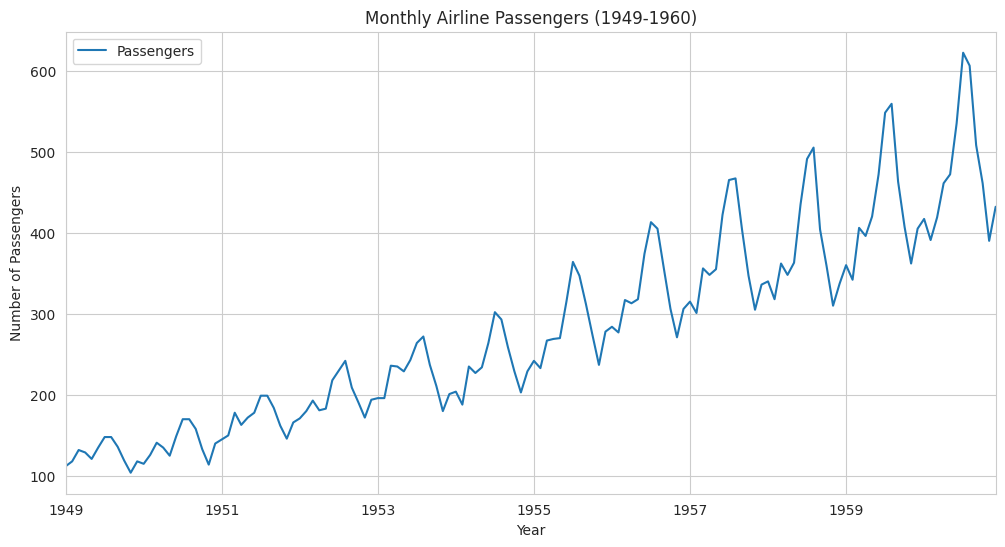

In [12]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

In [14]:
df.shape


(144, 1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [17]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [23]:
df.isnull().sum().iloc[0]

np.int64(0)

Dataframe Shows no missing Values

/tmp/ipython-input-313558733.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(data_by_year, labels=years)


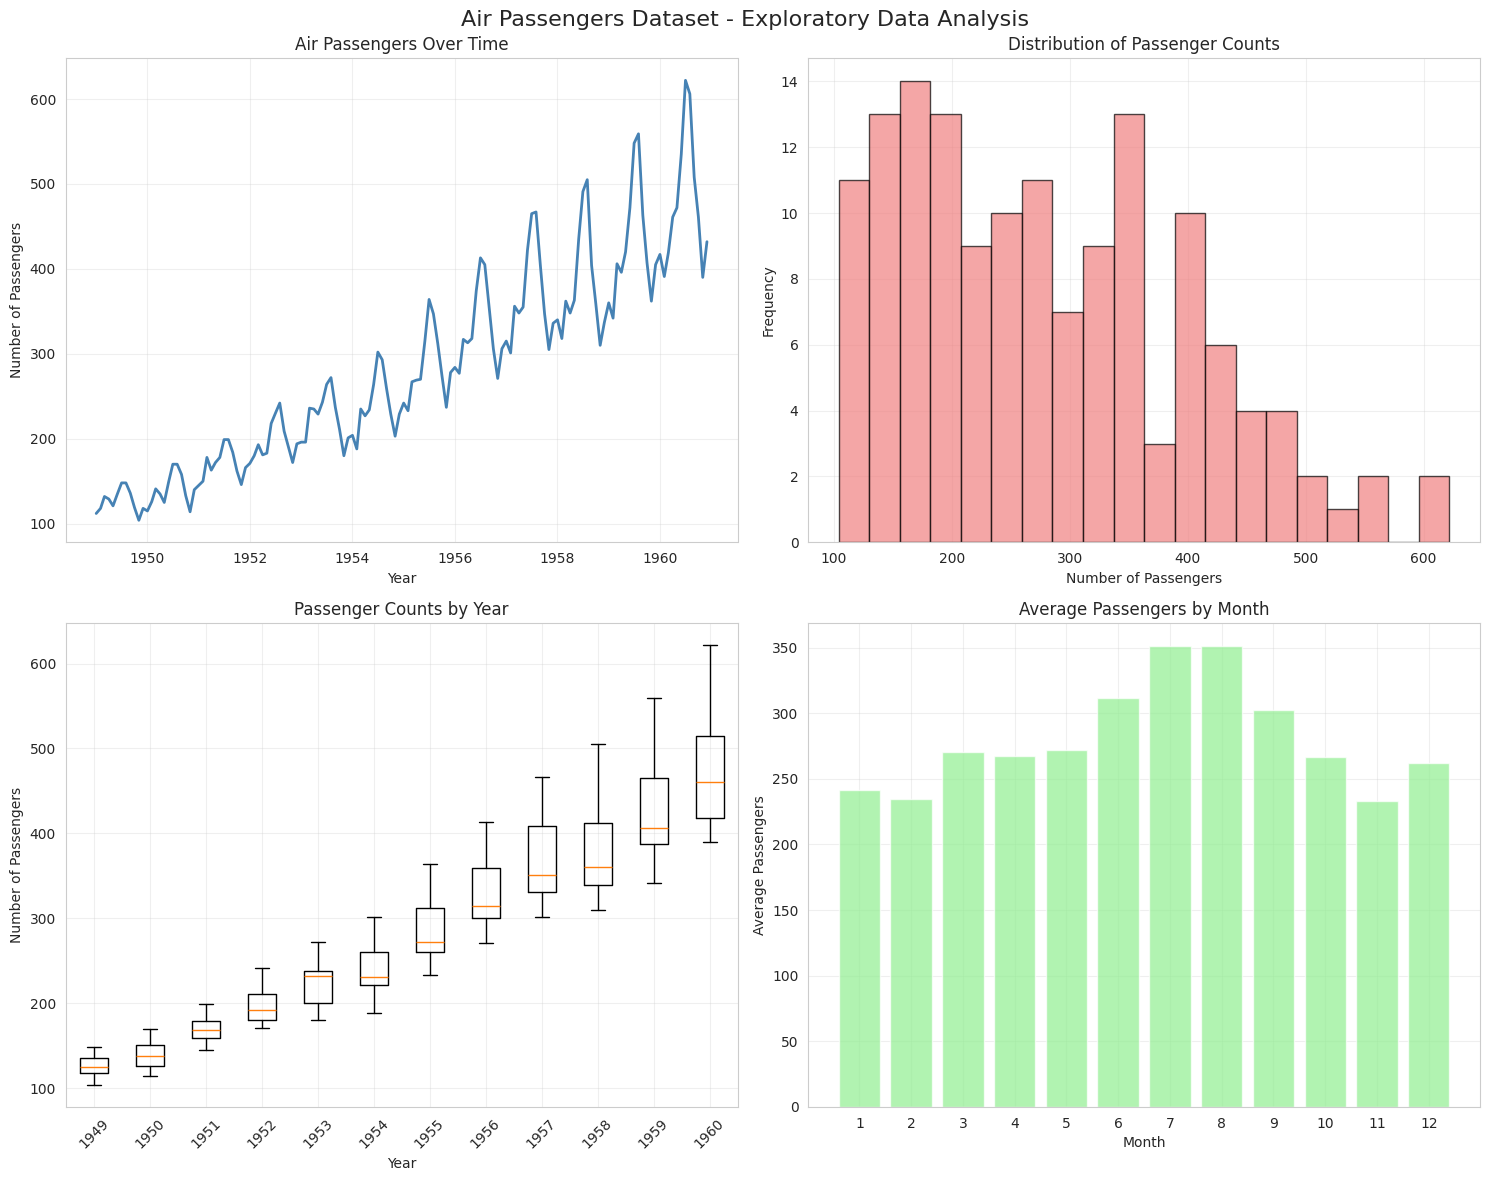

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Air Passengers Dataset - Exploratory Data Analysis', fontsize=16)

# Time series plot
axes[0, 0].plot(df.index, df.iloc[:, 0], linewidth=2, color='steelblue')
axes[0, 0].set_title('Air Passengers Over Time')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Passengers')
axes[0, 0].grid(True, alpha=0.3)

# Distribution histogram
axes[0, 1].hist(df.iloc[:, 0], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Passenger Counts')
axes[0, 1].set_xlabel('Number of Passengers')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Box plot by year
df_copy = df.copy()
df_copy['Year'] = df_copy.index.year
years = sorted(df_copy['Year'].unique())
data_by_year = [df_copy[df_copy['Year'] == year][df_copy.columns[0]].values for year in years]
axes[1, 0].boxplot(data_by_year, labels=years)
axes[1, 0].set_title('Passenger Counts by Year')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Number of Passengers')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Monthly seasonality
df_copy['MonthNum'] = df_copy.index.month
monthly_avg = df_copy.groupby('MonthNum')[df_copy.columns[0]].mean()
axes[1, 1].bar(range(1, 13), monthly_avg.values, color='lightgreen', alpha=0.7)
axes[1, 1].set_title('Average Passengers by Month')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Passengers')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#Insights

* Timseries plot shows strong upward trend-  Passengers increased from 100 in 1949 to 600+ by 1960-61 (6x growth over 12 years)

* Distribution histogram shows right-skewed distribution -  Most observations cluster in the 100-300 range

* BoxPlot shows regular seasonal patterns - increasing variance - consitent YOY increase.

* Bar chart shows clear monthly spikes - seasonal variation


In [37]:
#df_copy['Month'] = df_copy.index.month

In [32]:
#df_copy['Month']

,Month
Month,
1949-01-01,1
1949-02-01,2
1949-03-01,3
1949-04-01,4
1949-05-01,5
...,...
1960-08-01,8
1960-09-01,9
1960-10-01,10


## Timeseries decomposition

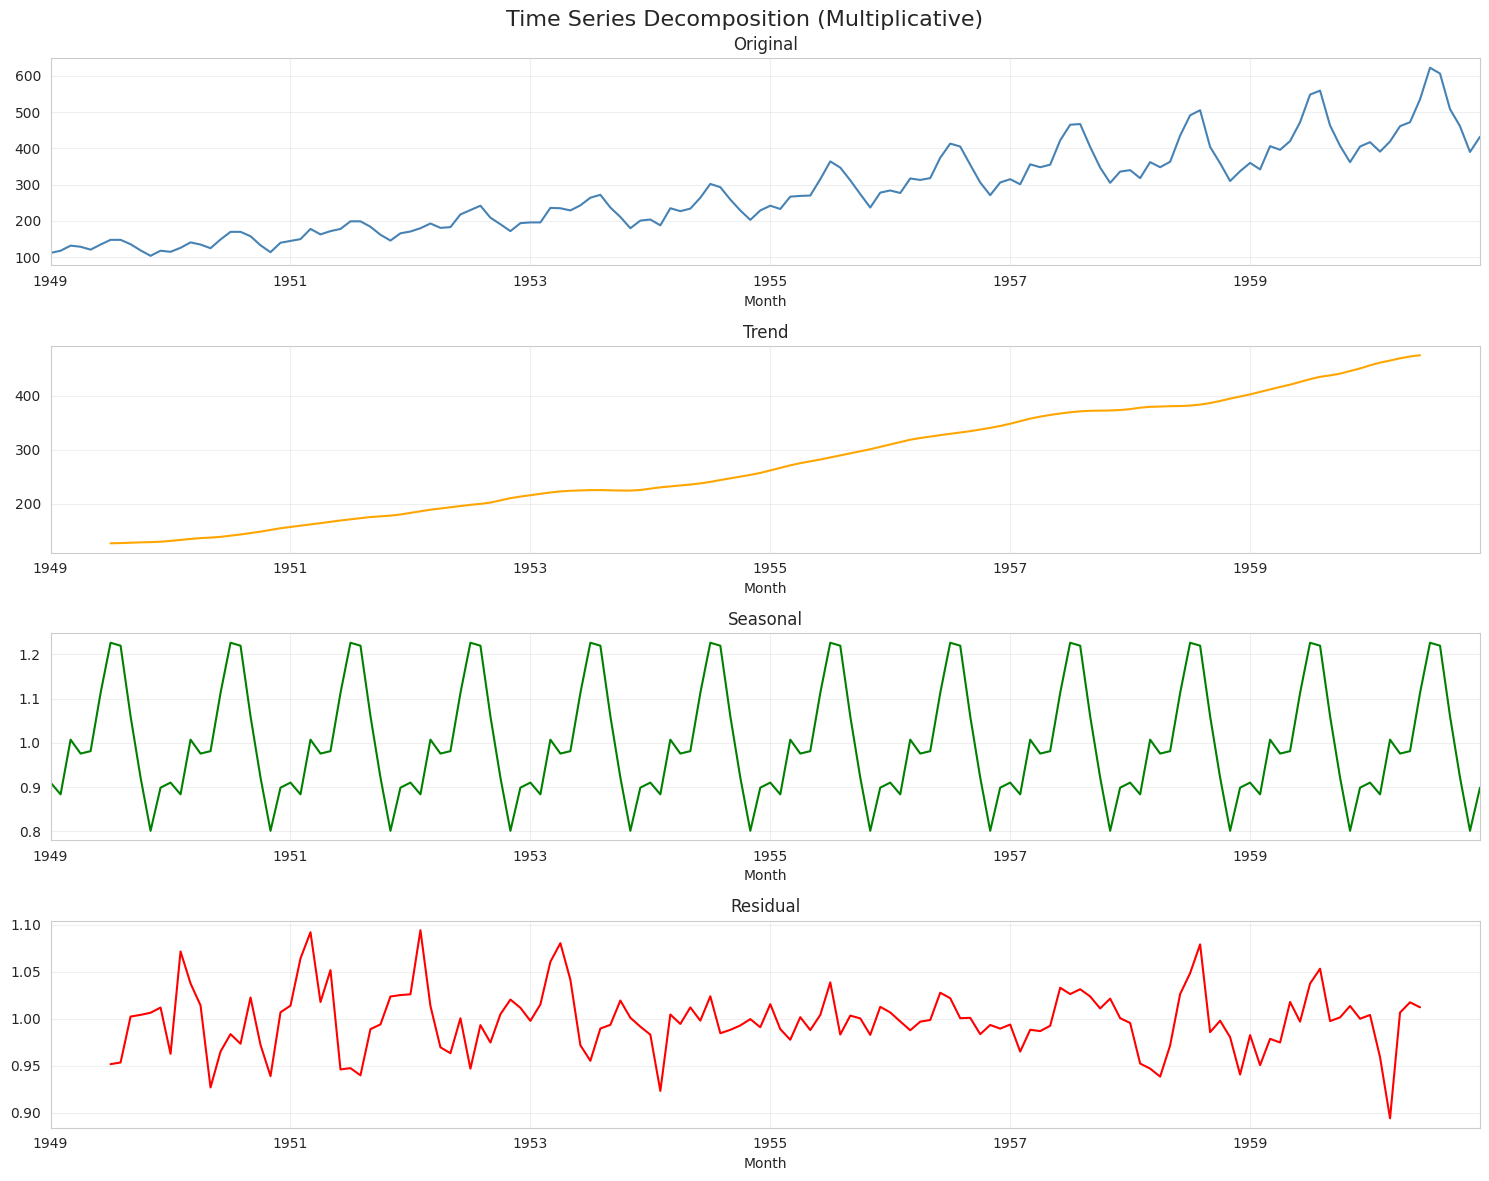

In [40]:
decomposition = sm.tsa.seasonal_decompose(df.iloc[:, 0], model='multiplicative', period=12)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('Time Series Decomposition (Multiplicative)', fontsize=16)

decomposition.observed.plot(ax=axes[0], title='Original', color='steelblue')
decomposition.trend.plot(ax=axes[1], title='Trend', color='orange')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal', color='green')
decomposition.resid.plot(ax=axes[3], title='Residual', color='red')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#Info - Know about Residuals:

* Residuals are the unexplained variations or errors that remain after a time series model has been fitted to the data
* They are calculated as the difference between the actual observed values and the values predicted by the model at each time step (Actual Value - Predicted Value).

* Analyzing residuals is crucial for evaluating how well a model fits the data, as they should resemble random "white noise" without discernible patterns like trends, seasonality, or autocorrelation.

Residuals appear to be 'white noise' if abs(decomposition.resid.mean()) < 0.1 else 'not white noise'


# Stationary Tests

A time series is said to be stationary if its statistical properties—specifically the mean, variance, and autocorrelation—are all constant over time.

Why is it important? Stationary series are easier to model and forecast. If a series is stationary, its past behavior is a good predictor of its future behavior. Our passenger data is clearly non-stationary because its mean (the trend is increasing) and variance (the seasonal swings are growing) are not constant.

In [46]:
series = df.iloc[:]

series

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [50]:
def perform_adf_test(data, title):
    result = adfuller(data, autolag='AIC')
    print(f"\n{title}:")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.6f}")

    is_stationary = result[1] <= 0.05
    print(f"Result: {'Stationary' if is_stationary else 'Non-stationary'}")
    return is_stationary

In [51]:
# Test original series
is_stationary_orig = perform_adf_test(series, "Original Series - ADF Test")




Original Series - ADF Test:
ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.481682
	5%: -2.884042
	10%: -2.578770
Result: Non-stationary


>>> Result: The p-value is 0.99, which is much greater than 0.05.

# Turn non-stationary data to stationary


In [58]:
# Test first difference
first_diff = series.diff().dropna()
is_stationary_diff1 = perform_adf_test(first_diff, "First Difference - ADF Test")



First Difference - ADF Test:
ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.481682
	5%: -2.884042
	10%: -2.578770
Result: Non-stationary


In [60]:
if not is_stationary_diff1:
        second_diff = first_diff.diff().dropna()
        is_stationary_diff2 = perform_adf_test(second_diff, "Second Difference - ADF Test")



Second Difference - ADF Test:
ADF Statistic: -16.384232
p-value: 0.000000
Critical Values:
	1%: -3.481682
	5%: -2.884042
	10%: -2.578770
Result: Stationary


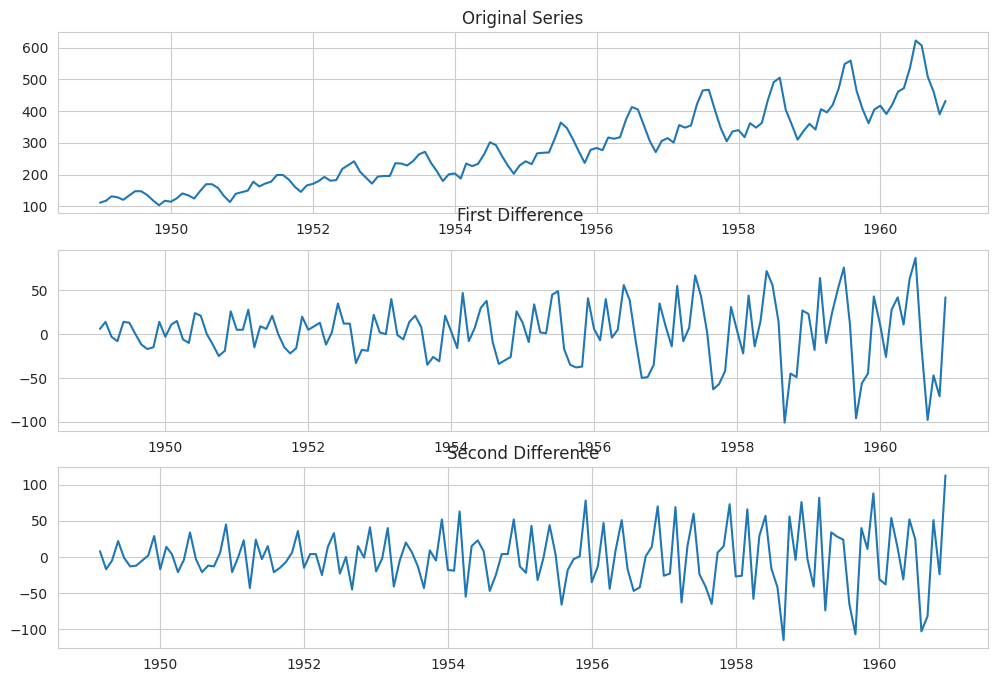

In [67]:
plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(series)
plt.title('Original Series')

plt.subplot(3,1,2)
plt.plot(first_diff)
plt.title('First Difference \n')

plt.subplot(3,1,3)
plt.plot(second_diff)
plt.title('Second Difference')
plt.show()

In [69]:
# Recommended differencing order - d = 2 since p reached normality after second differentiation

## Auto Correlation Analysis:



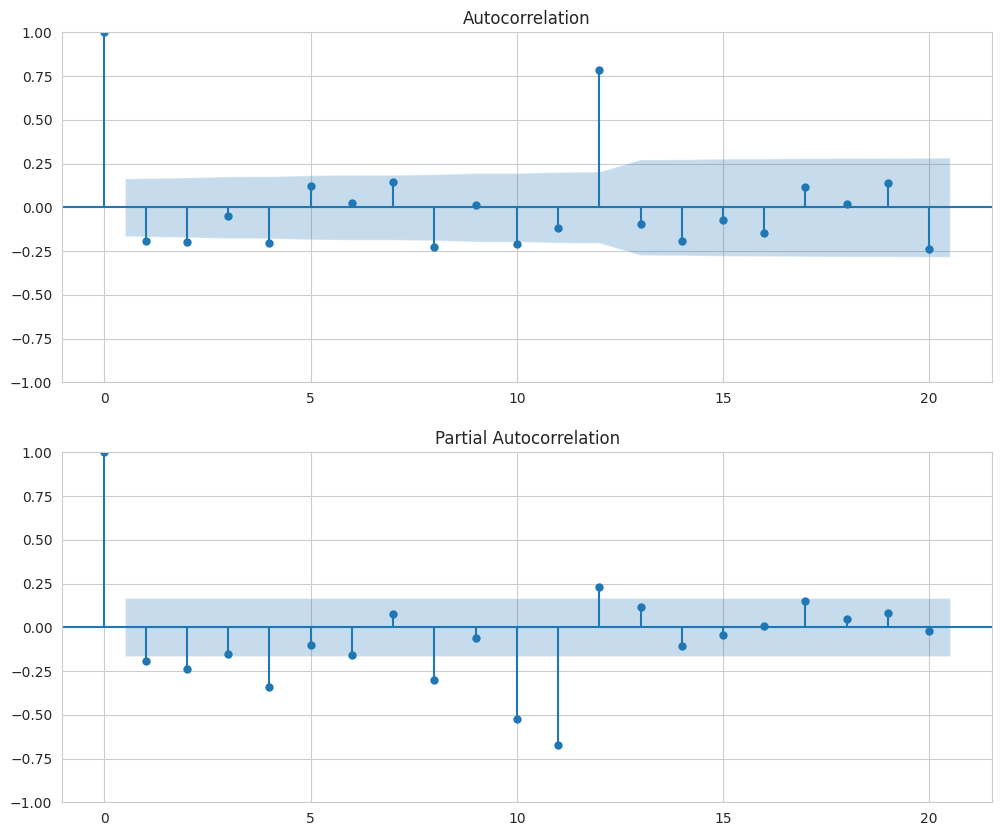

In [203]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(second_diff, ax=ax1, lags=20)
plot_pacf(second_diff, ax=ax2, lags=20)
plt.show()

PACF Plot: Cuts off sharply after lag 1.
ACF Plot: Also seems to cut off after lag 1.

Lets try with arima(p,d,q) -> arima(1, 2, 1)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


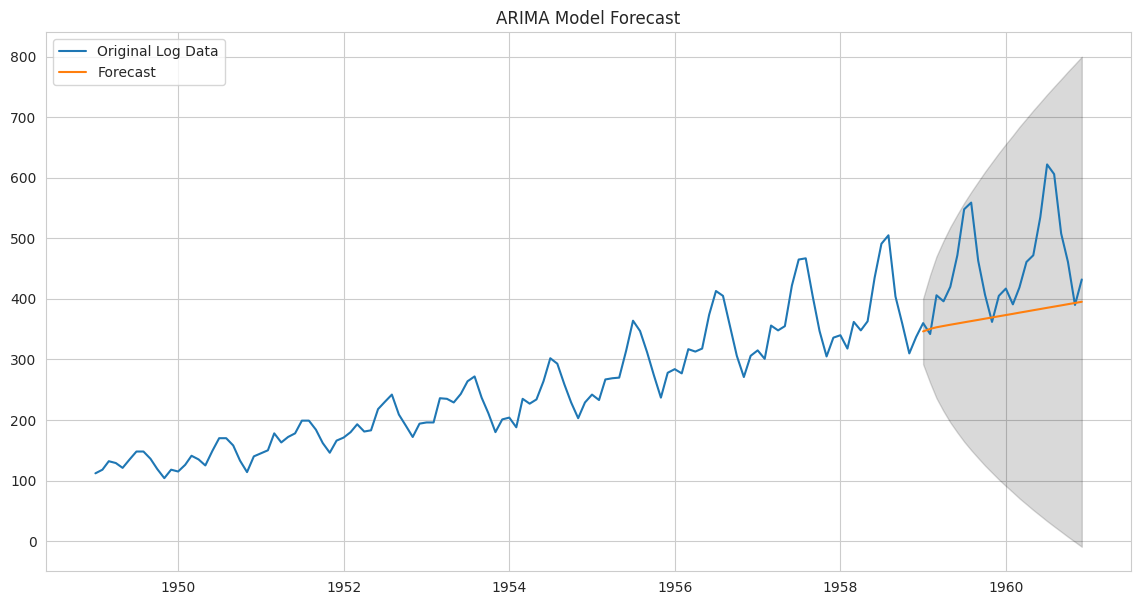

In [290]:
# Split data into training and test sets
train_data = series[:'1958']
test_data = series['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 2, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(series, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

## Insights:

* Continues the historical growth pattern instead of staying flat

* Better Level Continuity

* No major discontinuity at the forecast boundary
Logical progression from last observed values

Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -696.464
Date:                Sun, 14 Sep 2025   AIC                           1398.928
Time:                        11:18:31   BIC                           1407.796
Sample:                    01-01-1949   HQIC                          1402.532
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3130      0.100      3.127      0.002       0.117       0.509
ma.L1         -0.9998      5.946     -0.168      0.866     -12.655      10.655
sigma2      1034.0044   6187.776     

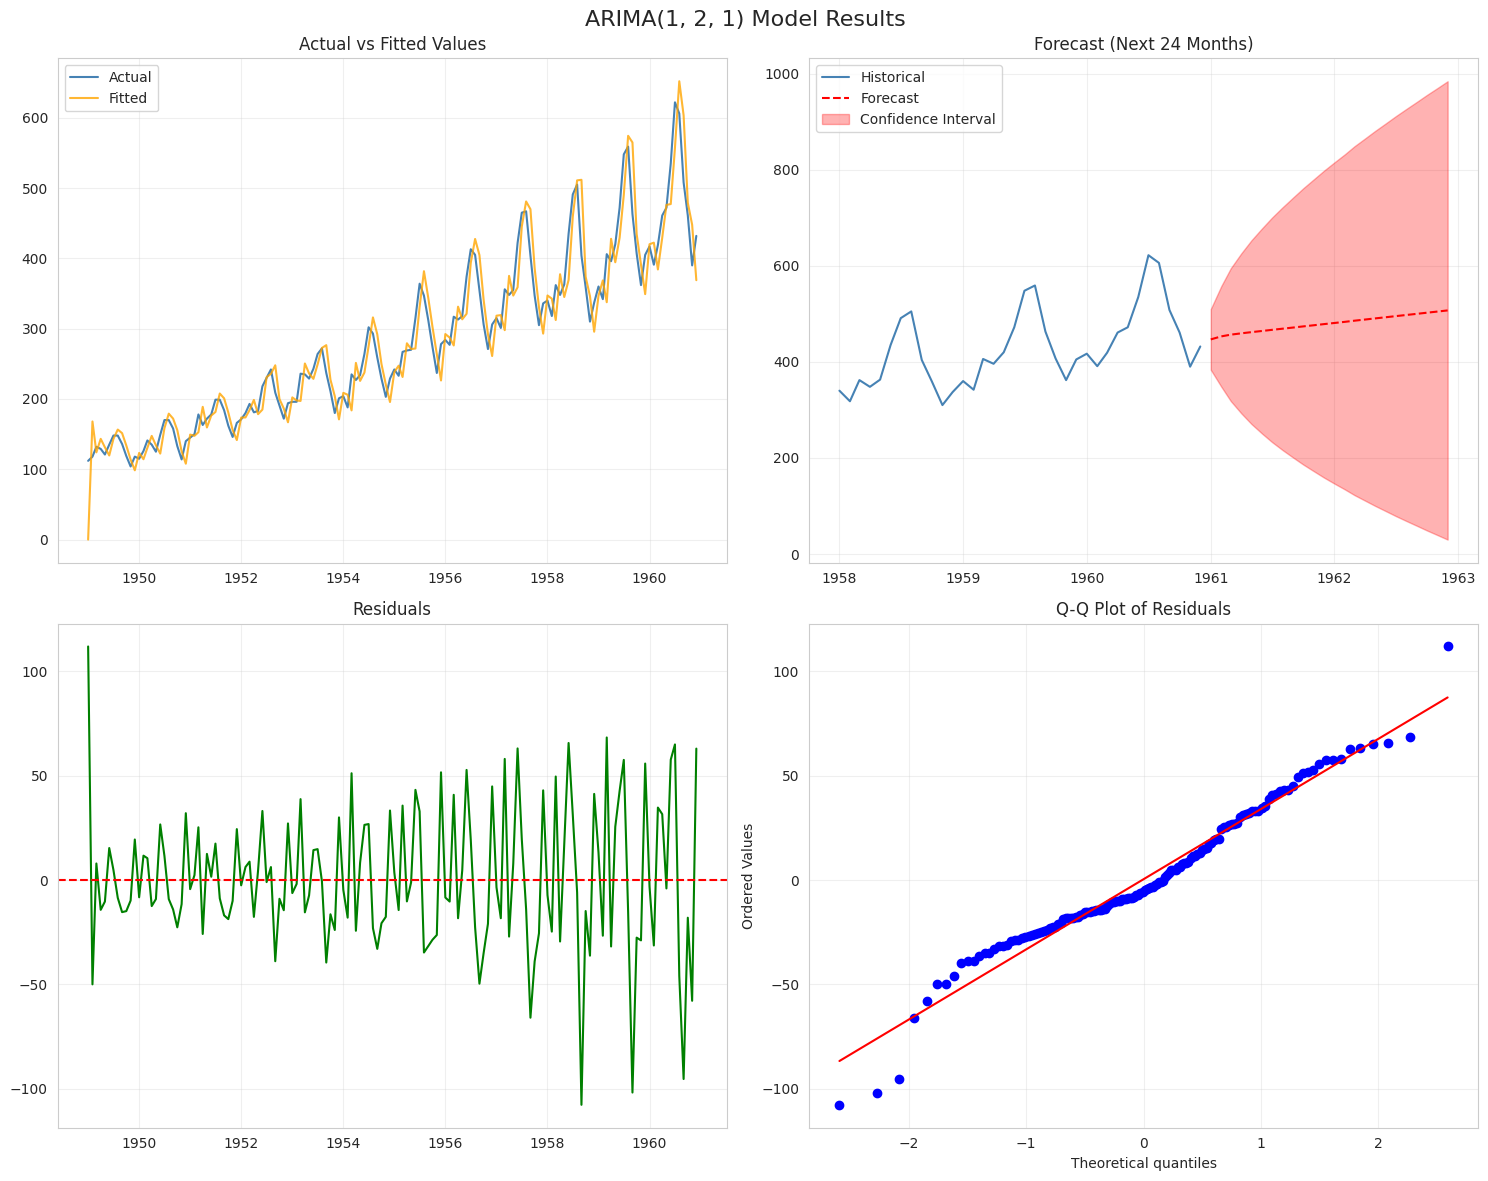

In [291]:
print("Model Summary:")
print(fitted_model.summary())

# Generate predictions
forecast_steps = 24  # 2 years ahead
forecast = fitted_model.forecast(steps=forecast_steps)
conf_int = fitted_model.get_forecast(steps=forecast_steps).conf_int()

# Calculate residuals
residuals = fitted_model.resid

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'ARIMA{(1,2,1)} Model Results', fontsize=16)

# Fitted values vs actual
axes[0, 0].plot(series.index, series.values, label='Actual', color='steelblue')
axes[0, 0].plot(series.index, fitted_model.fittedvalues, label='Fitted', color='orange', alpha=0.8)
axes[0, 0].set_title('Actual vs Fitted Values')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Forecast plot
last_date = series.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

axes[0, 1].plot(series.index[-36:], series.values[-36:], label='Historical', color='steelblue')
axes[0, 1].plot(forecast_dates, forecast, label='Forecast', color='red', linestyle='--')
axes[0, 1].fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                      color='red', alpha=0.3, label='Confidence Interval')
axes[0, 1].set_title('Forecast (Next 24 Months)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residuals plot
axes[1, 0].plot(residuals, color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_title('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Q-Q plot of residuals
from scipy import stats
stats.probplot(residuals.dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [217]:
series.values.shape

(144, 1)

In [218]:
arima_result.fittedvalues

,0
Month,
1949-01-01,0.000000
1949-02-01,168.009676
1949-03-01,124.040722
1949-04-01,143.199785
1949-05-01,131.500785
...,...
1958-08-01,509.946430
1958-09-01,511.561429
1958-10-01,375.846292


## Building Seasonal Arima  

In [229]:
# 1. Apply log transformation to stabilize the variance
df_log = np.log(series['Passengers'])

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


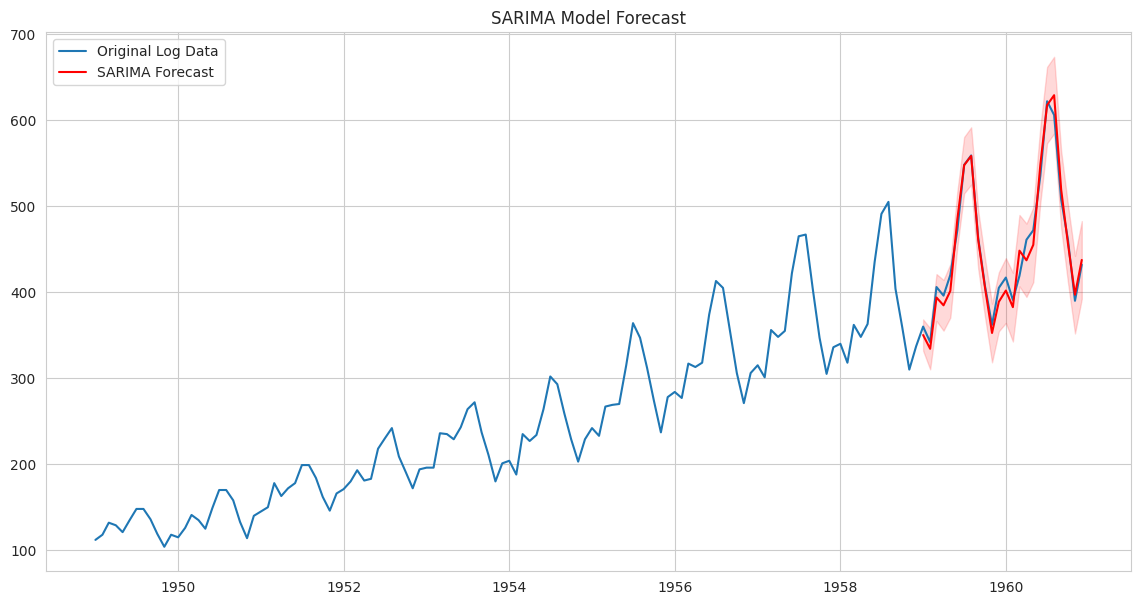

In [281]:
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 0, 0),
                                          seasonal_order=(1, 0, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(series, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

In [282]:
#Evaluation

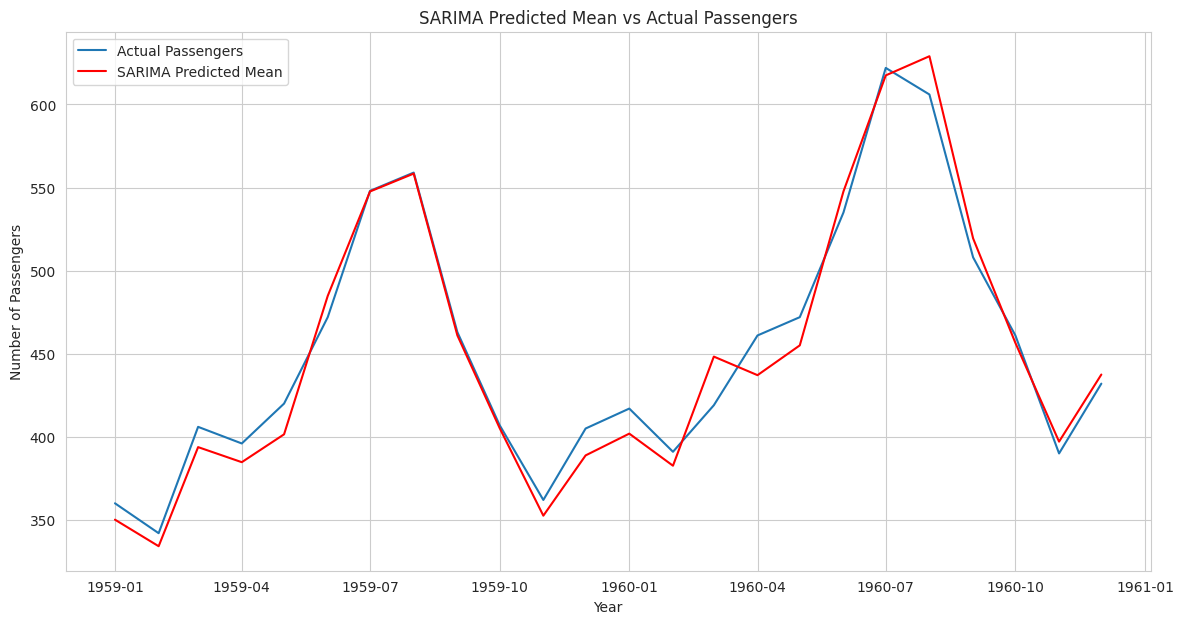

In [283]:
# Plot SARIMA predicted mean vs actual test data
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data.values, label='Actual Passengers')
plt.plot(sarima_forecast.predicted_mean.index, sarima_forecast.predicted_mean.values, label='SARIMA Predicted Mean', color='red')
plt.title('SARIMA Predicted Mean vs Actual Passengers')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [284]:
# Calculate RMSE for SARIMA model
rmse_sarima = np.sqrt(mean_squared_error(test_data, sarima_forecast.predicted_mean))
print(f"SARIMA Model RMSE: {rmse_sarima:.4f}")

SARIMA Model RMSE: 13.3143


In [287]:
# Create a DataFrame to compare actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Passengers': test_data['Passengers'],
    'SARIMA Predicted': sarima_forecast.predicted_mean
})

comparison_df

,Actual Passengers,SARIMA Predicted
1959-01-01,360,350.154265
1959-02-01,342,334.170168
1959-03-01,406,393.805269
1959-04-01,396,384.738810
1959-05-01,420,401.503828
1959-06-01,472,484.807750
1959-07-01,548,547.635910
1959-08-01,559,558.395286
1959-09-01,463,461.026339
1959-10-01,407,405.268175
